# Info and Instructions

## 1 Your Objective (**Read Carefully**)
The year is 2051, fake news has drastically destabilized our political system.
70% of Canadians believe at least one of the major conspiracy theories circulating the country at any given time.

A new type of political party has developed (lets call them Party Q), that relies heavily on fake news and country division and fear
to win the support of voters. 
Party Q has been gaining major traction in Canadian politics at all levels, 
and certain provinces are currently being occupied by Party Q Political candidates.

The current prime-minister is a stable moderate but there are fears around the rising support for the
a Party Q opposition even at the federal level.

You've been asked by the Canadian Government to build a proof of concept model to detect fake news. 
If successful this model will be deployed and applied to every political speech/comment/post made in this country
at all levels of government, it will be used for both real-time fact checking, and flagging of facts to be sent to proffessional fact checkers.

The fate of our nation rests in your capable hands.

The prime minister needs 3 results from your model:
1. Needs to flag false posts ("pants-fire" or "false") with a recall of at least 70% (these will be sent to proffessional fact checkers)
2. Needs to flag "true" posts with a precision of at least 95% (these will be used in real-time to verify facts during presentations)
3. Needs to flag "pants-fire" posts with a precision of at least 95% (these will be used in real-time to contradict statements during presentations)
(See dataset information for more clarification around labels)

## 2 Dataset Information:
"We consider six fine-grained labels for
the truthfulness ratings: pants-fire, false, barelytrue, half-true, mostly-true, and true. The distribution of labels in the LIAR dataset is relatively
well-balanced: except for 1,050 pants-fire cases,
the instances for all other labels range from 2,063
to 2,638." - https://arxiv.org/pdf/1705.00648.pdf

## 3 Submission Instructions (**Read Carefully**)
- To submit:
  1. you cannot edit this notebook directly. **Save a copy** to your drive, and make sure to identify yourself in the title using name and student number
  2. **Ensure** you have implemented all the nececessary functions
  3. **Provide answers** to the questions in the conclusion cell
  4. Unlike previous assignments, please **submit all three formats: .py, .ipynb, and html** (see https://torbjornzetterlund.com/how-to-save-a-google-colab-notebook-as-html/)
    - The notebook and html submissions should show the completion of your best performing run
  5. **Ensure** your nNotebook can _restart and run all_
  6. The mark will be assessed on the implementation of the functions with #TODO
  7. **Do not change anything outside the marked functions**  unless in the further exploration section
  8.  Do not use any additional libraries than the ones listed below (you may import additional modules from those libraries if needed)
  9. The mark is primarily based on correctness. However, since you are responsible for optimally tuning this model, meeting high performance is required, you should be able to at least match the results given in the paper.

Changing your run time in colab to GPU will speed up the training drastically


In [2]:
!pip install datasets
!pip install transformers
!pip install pandas

from datasets import load_dataset
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

import numpy as np
from keras.utils import np_utils
import tensorflow as tf
from pandas_profiling import ProfileReport

from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LayerNormalization


dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')



     |████████████████████████████████| 194kB 7.6MB/s 
     |████████████████████████████████| 112kB 14.7MB/s 
     |████████████████████████████████| 245kB 15.1MB/s 
     |████████████████████████████████| 1.9MB 9.1MB/s 
     |████████████████████████████████| 3.2MB 51.6MB/s 
     |████████████████████████████████| 890kB 50.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=16f9eabda563065b798d629b451cfbde6904b59ece862e1e974bdaafe9273705
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Data Preparation

## Clean the text and your targets
Hints: 
1. Use the exploration cell to explore the data and identify cleaning steps
2. Inspect the tokenized sentences and ensure they make sense and can leverage already trained word embeddings
3. These resources will help you understand what type of cleaning will be required and how you can encode your text for the network:
    - a) Preprocessing: https://huggingface.co/transformers/preprocessing.html
    - b) Summary of tokenizers (DistilBERT uses WordPiece): https://huggingface.co/transformers/tokenizer_summary.html#wordpiece
4. Consider the text length, is this too big/small for DistilBERT? what impact would padding/truncation have?
5. In load data you generated a profiling report of this dataset, might be helpful to review that as well

In [376]:
def prepare_raw_data(df):
  raw_data = df.loc[:, ["id", "statement", "label"]]
  raw_data["label"] = raw_data["label"].astype('category')
  return raw_data

def load_data(save_dir="./"):
  dataset = load_dataset("liar")
  train = prepare_raw_data(pd.DataFrame(dataset["train"]))
  val = prepare_raw_data(pd.DataFrame(dataset["validation"]))
  test = prepare_raw_data(pd.DataFrame(dataset["test"]))
  return train, val, test
         
def clean_data(raw_data):
  # TODO: What data cleaning/filtering should you consider?
  # Hint: check for duplicates or contradictions
  # Hint: What is the minimum and maximum lengths of the statements?
  # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

  ### Converting object type to string
  raw_data = raw_data.convert_dtypes(convert_string=True)

  ## Copying to s string array for preprocessing
  raw_data_statement = raw_data['statement'].values
  
  

  clean_data = raw_data
  return clean_data

def extract_raw_text_and_y(clean_data):
  raw_text, raw_y = clean_data["statement"].values, clean_data["label"].values
  return raw_text, raw_y

def encode_text(text):
    # TODO: encode text using dbert_tokenizer
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    max_seq_len = 66
    input_ids, attention_mask = [],[]
    
    tokens = dbert_tokenizer.batch_encode_plus(text, max_length=max_seq_len, padding=True, truncation=True)
    input_ids=np.array(tokens['input_ids'])
    attention_mask=np.array(tokens['attention_mask'])

    return input_ids, attention_mask

def prepare_target(raw_y):
    # TODO: convert labels to 0/1
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # NOTE: labels map as follows: ['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire']
    # y should have:
    # column 0 = "pants-fire" or "false" posts
    # column 1 = "true" posts
    # column 2 = "pants-fire"
    lst_dict = []
    df = pd.DataFrame(columns=['col_0', 'col_1', 'col_2','original'])
    for row in raw_y:      
      if row == 0 : #false or Pants-fire
        #print(row)
        lst_dict.append({'col_0':1, 'col_1':0, 'col_2': 0, 'original':row})
      elif row == 3: #True
        #print(row)
        lst_dict.append({'col_0':0, 'col_1':1, 'col_2': 0, 'original':row})
      elif row == 5: #Pants fire
       #print(row)
       lst_dict.append({'col_0':0, 'col_1':0, 'col_2': 1, 'original':row})
      else : 
        #print(row)
       lst_dict.append({'col_0':0, 'col_1':0, 'col_2': 0, 'original':row})

    df1 = df.append(lst_dict)
    df1['col_0'] = df1.apply(lambda x: 1 if x['original']==5 else x['col_0'], axis=1)
    y = df1
    return y


# Modelling

## Build and Train Model

Resources:
- DistilBERT paper: https://arxiv.org/abs/1910.01108
- DistilBERT Tensorflow Documentation: https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel

In [377]:
def build_model(base_model, trainable=False, params={}):
    # TODO: build the model, with the option to freeze the parameters in distilBERT
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # Hint 1: the cls token (token for classification in bert / distilBERT)  corresponds to the first element in the sequence in DistilBERT
    # Hint 2: this guide may be helpful for parameter freezing: https://keras.io/guides/transfer_learning/
    # Hint 3: double check your number of parameters make sense
    # Hint 4: carefully consider your final layer activation and loss function
    max_seq_len = 66
    # Refer to https://keras.io/api/layers/core_layers/input/
    inputs = Input(shape = (max_seq_len,), dtype='int64', name='inputs')
    masks  = Input(shape = (max_seq_len,), dtype='int64', name='masks')

    #inputs = {'inputs': inputs, 'mask': mask}

    base_model.trainable = trainable

    #dbert_output = base_model(inputs, attention_mask=masks)
    #dbert_last_hidden_state = dbert_output.last_hidden_state

    dbert_last_hidden_state = base_model(inputs, attention_mask=masks)[0]

    print("bert shape",dbert_last_hidden_state.shape)

    cls_token = dbert_last_hidden_state[:,0,:]
    # Any additional layers should go here
    # use the 'params' as a dictionary for hyper parameter to facilitate experimentation

    pooled_output = Dense(128, activation='relu')(cls_token)
    pooled_output = Dropout(0.5)(pooled_output)
      
    col_0 = Dense(units=2, name='col_0', activation='relu')(pooled_output)

    col_1 = Dense(units=2, name='col_1' , activation='relu')(pooled_output)

    col_2 = Dense(units=2, name='col_2' , activation='relu')(pooled_output)

    my_outputs = {'col_0': col_0, 'col_1':col_1, 'col_2':col_2}

    #probs = Dense(2,  activation='softmax')(my_outputs)

    #probs = Dense(3,  activation='sigmoid')(my_outputs)

    #print("probs details", probs)

    model = keras.Model(inputs=[inputs, masks], outputs=my_outputs, name='BERT_MultiLabel_MultiClass')
    model.summary()
    return model

In [378]:
def compile_model(model):
    # TODO: compile the model, include relevant auc metrics when training
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # Hint: you may want to read up on the "multi_label" parameter in the keras AUC metrics
    
    optimizer = Adam(learning_rate=5e-05,epsilon=1e-08, decay=0.01,clipnorm=1.0)
    #set loss and metrics
    loss= {
            'col_0': CategoricalCrossentropy(from_logits = True),
            'col_1': CategoricalCrossentropy(from_logits = True),
            'col_2': CategoricalCrossentropy(from_logits = True)
          }
    metric = {
              'col_0': CategoricalAccuracy('accuracy'),
              'col_1': CategoricalAccuracy('accuracy'),
              'col_2': CategoricalAccuracy('accuracy')
             }
    model.compile(optimizer=optimizer, loss = loss, metrics = metric )

    return model

In [390]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):
    # TODO: train the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    #history = model.fit(model_inputs_and_masks_train, y_train=[], batch_size=batch_size,
     #                   validation_data=(model_inputs_and_masks_val, y_val), epochs=num_epochs)

    train_inp = model_inputs_and_masks_train['inputs']
    train_mask = model_inputs_and_masks_train['masks']
    val_inp = model_inputs_and_masks_val['inputs']
    val_mask = model_inputs_and_masks_val['masks']

    col_0 = to_categorical(y_train['col_0'])
    col_1 = to_categorical(y_train['col_1'])
    col_2 = to_categorical(y_train['col_2'])

   
    # history = model.fit( x=[train_inp,train_mask], y=[col_0],validation_split=0.2, batch_size=64, epochs=1)
    
    #history = model.fit( x=[train_inp,train_mask] , y=output_arr , validation_split=0.2, batch_size=64, epochs=1)

    history = model.fit(x={'inputs': train_inp, 'masks': train_mask}, 
                        y={'col_0': col_0, 'col_1': col_1, 'col_2': col_2},
                        validation_split=0.2, batch_size=64, epochs=15
                        )

    print(100)
    return model, history

In [382]:
to_categorical(train_y['col_2'])

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

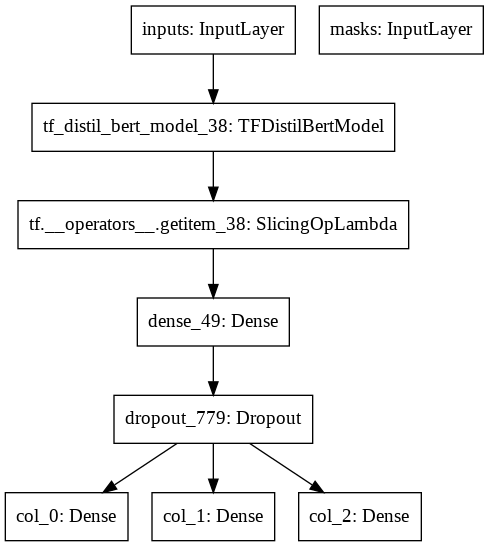

In [179]:
tf.keras.utils.plot_model(model)

In [7]:
def evaluate_model(model, model_inputs_and_masks_test, y_test):
    # TODO: evaluate the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # HINT: for pr_auc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html 

    eval_dict = {
        "false": {
            "pr_auc": ???, "pr_auc_random_guess": ???, 
            "roc_auc": ???, "roc_auc_random_guess": ???, 
            "precision": ???, "recall": ???
        }, 
        "true": {
            "pr_auc": ???, "pr_auc_random_guess": ???, 
            "roc_auc": ???, "roc_auc_random_guess": ???, 
            "precision": ???, "recall": ???
        }, 
        "pants": {
            "pr_auc": ???, "pr_auc_random_guess": ???, 
            "roc_auc": ???, "roc_auc_random_guess": ???, 
            "precision": ???, "recall": ???
        }
    }
    return eval_dict

SyntaxError: ignored

# Execution



In [391]:
## DO NOT Change
train, val, test = load_data()
train_raw_x, train_raw_y = extract_raw_text_and_y(clean_data(train))
val_raw_x, val_raw_y = extract_raw_text_and_y(clean_data(val))
test_raw_x, test_raw_y = extract_raw_text_and_y(clean_data(test))

train_input, train_mask = encode_text(train_raw_x)
train_y = prepare_target(train_raw_y)

val_input, val_mask = encode_text(val_raw_x)
val_y = prepare_target(val_raw_y)

test_input, test_mask = encode_text(test_raw_x)
test_y = prepare_target(test_raw_y)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}


Using custom data configuration default
Reusing dataset liar (/root/.cache/huggingface/datasets/liar/default/1.0.0/1a6abd9863f27194da30fcb66988477abfa3780df3b0ad1d0032979c48ec7918)


In [384]:
train_input.shape, test_input.shape, train_y.shape

((10269, 66), (1283, 66), (10269, 4))


Use the cell below to execute and experiment with your model

In [392]:
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model = build_model(dbert_model, params={})
model = compile_model(model)
model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, train_y, val_y, batch_size=64, num_epochs=10)

#eval_dict = evaluate_model(model, test_model_inputs_and_masks, test_y)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


bert shape (None, 66, 768)
1st pooled output shape (None, 128)
2nd pooled output shape (None, 128)
3rd pooled output shape (None, 128)
4th pooled output shape (None, 128)
Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 66)]         0                                            
__________________________________________________________________________________________________
masks (InputLayer)              [(None, 66)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_42 (TFDist TFBaseModelOutput(la 66362880    inputs[0][0]                     
                                                                 masks[0][0]                      
_

In [393]:
test_inp = test_model_inputs_and_masks['inputs']
test_mask = test_model_inputs_and_masks['masks']

col_0 = to_categorical(test_y['col_0'])
col_1 = to_categorical(test_y['col_1'])
col_2 = to_categorical(test_y['col_2'])

model_eval = model.evaluate(  
                        x={'inputs': test_inp, 'masks': test_mask}, 
                        y={'col_0': col_0, 'col_1': col_1, 'col_2': col_2},
)



41/41 [==============================] - 3s 75ms/step - loss: 1.2827 - col_0_loss: 0.5814 - col_1_loss: 0.4474 - col_2_loss: 0.2539 - col_0_accuracy: 0.7334 - col_1_accuracy: 0.8355 - col_2_accuracy: 0.9283


In [394]:
pred = model.predict([test_input, test_mask])

In [395]:
pred

{'col_0': array([[0.9850693 , 0.        ],
        [1.0673974 , 0.        ],
        [0.72135866, 0.        ],
        ...,
        [0.8490226 , 0.        ],
        [0.4500274 , 0.        ],
        [0.81230843, 0.        ]], dtype=float32),
 'col_1': array([[1.7410517, 0.       ],
        [1.6605916, 0.       ],
        [2.0349128, 0.       ],
        ...,
        [1.8107558, 0.       ],
        [1.7057273, 0.       ],
        [1.833049 , 0.       ]], dtype=float32),
 'col_2': array([[2.2151012, 0.       ],
        [2.3828323, 0.       ],
        [2.4055572, 0.       ],
        ...,
        [2.04493  , 0.       ],
        [2.2472284, 0.       ],
        [2.4473338, 0.       ]], dtype=float32)}

In [396]:
test_y

,col_0,col_1,col_2,original
0,0,1,0,3
1,1,0,0,0
2,1,0,0,0
3,0,0,0,1
4,1,0,1,5
...,...,...,...,...
1278,0,0,0,1
1279,0,0,0,4
1280,0,0,0,4
1281,0,0,0,4


## Conclusions (TODO)
TODO: Make Your Final Conclusions About Your Model (Answer questions below, answer in this cell)
- a) What is driving your model's decisions?
- b) Is your model biased in some ways? If so how? 
- c) Does your model accomplish the objectives? If not, is your model useful and how can you justify this?

# Further exploration (REMOVE ALL CODE AFTER THIS CELL BEFORE SUBMISSION)
Any code after this is not evaluated, and must be removed before submission.
Leaving code below will result in losing marks.